# Semi-avansert pandas
Vi har nå vært igjennom basics med pandas. Det er veldig mye du kan gjøre med pandas, og vi kan ikke dekke alt i dette kurset

## Vi gir en liten innføring i:
* Multiindex/Multicolumn dataframes
* Filtrering
* Omforme med `.melt()`, `.pivot()`
* ...

# Multiindex dataframes
* Multiindex har «tupler» som index: `[(Alta, 1991), (Alta, 1992), .... , (Ålesund, 1991), (Ålesund,  1992)]`
* Vi kan lage en slik multiindex med feks `.set_index(["Sted", "År"])`
* Vi slår nå opp i dataframe med tupler, `df.loc[("Molde", 2001), "Fraflytning"]`
* Vi kan også slå opp i kun ytterste index, `df.loc["Molde"]`

In [22]:
import pandas as pd
df = pd.read_csv("eu_GDP.csv") # teina010 dataset fra eurostat, (GDP and main components (output, expenditure and income))

land = df["Geopolitical entity (reporting)"].unique() #Områder som er med
df["Time"] = pd.PeriodIndex(df["Time"], freq="Q") #Gjør om til pandas.Period i stedet for "strenger"

df = df.set_index(["Geopolitical entity (reporting)","Time"]) #Setter multiindex - område ytterst, år innerst

#Slår opp i spesifikt datapunkt
df.loc[("Germany", "2022Q3")]

#Henter data for Norge
print("BNP norge 2. kvartal 23:", df.loc[("Norway", "2023Q2"), "value"])

# i to steg
data_norge = df.loc["Norway"]
data_norge

BNP norge 2. kvartal 23: 109682.5


,value
Time,
2021Q3,106567.7
2021Q4,125219.8
2022Q1,135316.3
2022Q2,140387.0
2022Q3,159059.1
2022Q4,129872.3
2023Q1,120455.4
2023Q2,109682.5
2023Q3,108190.4


## Slice og hente områder med data
* Dersom vi vil hente ut data litt mer komplisert enn kun fra ytterste indeks bør vi først sortere indeksen
* Det gjøres med `df.sort_index(level=...)`
* Her er `level`et heltall, eller etikette eller en liste av heltall/etiketter som forteller hvilken nivå vi skal sortere på
* Vi teller "nivåene" fra innerst=0 til ytterst=n-1, (1 dersom vi har 2 nivå)

In [32]:
df.sort_index(level=1) # Sortere på land
df.sort_index(level=0) # Sorterer år
df = df.sort_index(level=[0,1])
#Sorterer begge


### Slice
* Det blir litt mer komplisert når man skal slice multiindex dataframes
* Mitt tips er å bruke `df.xs(key, axis=0, level=None, drop_level=True)` ("cross section") når man skal hente ut hele nivåer
* Og `pd.IndexSlice` for mer komplisert slicing
* *Også kolonnene kan ha en "multiindex" Vi bruker da de samme teknikkene*

In [28]:
 # Hent ut data for 3. kvartal 2021, for alle land
df.xs("2022Q3", level="Time", drop_level=False)

,,value
Geopolitical entity (reporting),Time,
European Union - 27 countries (from 2020),2022Q3,4076031.0
"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",2022Q3,3445011.7
Euro area – 20 countries (from 2023),2022Q3,3462191.7
Euro area - 19 countries (2015-2022),2022Q3,3445011.7
Belgium,2022Q3,139907.0
Bulgaria,2022Q3,21910.1
Czechia,2022Q3,72921.6
Denmark,2022Q3,98593.7
Germany,2022Q3,993638.0


#### pd.IndexSlice
* IndexSlice er spesialbygget for å slice over multiindekser
* Det finnes flere måter å gjøre dette på, men de er litt rare og vanskelige
* Med `IndexSlice` lager vi først en "slicer": `idx = pd.IndexSlice`
* Denne bruker vi sammen med `.loc[]` til å slice ganske intuitivt over flere indeksnivåer, (funker også lang kolonnene)
* `data = df.loc[idx["Alta":"Molde", 1950:1970], :]`

In [35]:
idx = pd.IndexSlice
 # Slice: Land fra tyskland til sverige mellom 2022Q1 til 2023Q3
df.loc[idx["Germany":"Sweden", "2022Q1":"2023Q3"], :] 

value
Geopolitical entity (reporting) Time             
Germany                         2022Q1   962521.0
                                2022Q2   979029.0
                                2022Q3   993638.0
                                2022Q4  1012073.0
                                2023Q1  1029719.0
...                                           ...
Sweden                          2022Q3   139331.2
                                2022Q4   137742.5
                                2023Q1   136965.7
                                2023Q2   134285.4
                                2023Q3   132872.4

[147 rows x 1 columns]

## Filtrering
* Ofte holder det ikke å slice data -- vi trenger å filtrere de ut
* Kanskje vi vil velge ut data for land med befolkning større enn 10 millioner *OG* BNP større enn ...
* I pandas kan vi filtrere i `.loc[..]` ved bruk av boolsk aritmetikk
* Vi kan også bruke `.query("spørring")`

## Boolsk filtrering
* Gjør vi noe som `df["alder"] > 25` returnerer pandas en dataserie med `True`overalt hvor "alder" er større enn 25
* Vi kan bruke denne dataserien til å slå opp i alle radene hvor serien inneholder true:

  ```python
  df.loc[df["alder"] > 25] # Returnerer alle rader hvor "alder" kolonnen inneholder et tall over 25
  ```
* Vi kan kombinere ulike boolske serier med `&` ( and ) og `|` (eller) 

Tabell med ulike måter å bruke dette til å filtrere ut data:
| Beskrivelse                                                 | Eksempel                                           |
|-------------------------------------------------------------|----------------------------------------------------|
| Filter rader der `Alder` er større enn 20                   | `df[df['Alder'] > 20]`                             |
| Filter rader der `Navn` inneholder 'e' (case-insensitive)   | `df[df['Navn'].str.contains('e', case=False)]`     |
| Filter rader der `Alder` er mellom 20 og 30                 | `df[(df['Alder'] >= 20) & (df['Alder'] <= 30)]`    |
| Filter rader der `Navn` ikke inneholder 'a'                 | `df[~df['Navn'].str.contains('a', case=False)]`    |
| Filter rader der `Poeng` er større enn 50 eller `Alder` er mindre enn 25 | `df[(df['Poeng'] > 50) \| (df['Alder'] < 25)]` |
| Filter rader der `Land` er enten "Norge" eller "Sverige"    | `df[df['Land'].isin(['Norge', 'Sverige'])]`        |
| Filter rader med eksakte match i `Postnummer`               | `df[df['Postnummer'].isin([1234, 5678])]`          |
| Filter rader der `Navn` starter med 'B'                     | `df[df['Navn'].str.startswith('B')]`               |
| Filter rader der `Navn` slutter på 'e'                      | `df[df['Navn'].str.endswith('e')]`                 |


In [77]:
import pandas as pd
import numpy as np
df = pd.read_csv("folketall.csv", encoding="ISO-8859-1", sep="\t")

# Bytt ut ".." med np.nan
df = df.replace("..", np.nan)

#Gjør om data bortsett fra region til heltall
kolonner = list(df.columns)
kolonner.remove("region")
kolonner.remove("år")
konverteringstyper = { kolonnenavn: "Int64" for kolonnenavn in kolonner }
df=df.astype(konverteringstyper)
df.dtypes

#Gjør om år til periodindex
df["år"] = pd.PeriodIndex(df["år"], freq="Y")

#Lag multiindex
df = df.set_index(["region", "år"])
#Sorter index
df = df.sort_index(level=["region", "år"])

#litt slicing
# Cross section
df.xs("1990", level="år")

#indexslice (alle regioner, 2000 til 2023 ,døde til innflyttinger
idx = pd.IndexSlice
df.loc[idx[:, "2000":"2023"], "Døde":"Innflyttinger"]
#Gjør det samme som xs-eksempelet
df.loc[idx[:, "1990"], :]


# Slå opp alle år hvor færre enn 1000 døde (alle regioner)
df.loc[df["Døde"] < 1000]

#Slå opp alle rader hvor flere flyttet inn enn ut
df.loc[df["Innflyttinger"] > df ["Utflyttinger"]]

# Alle region/år hvor nettoinnflytting er positiv og befolkning er større enn 100,000
df[(df["Nettoinnflytting"] > 0) & (df["Befolkning 1. januar"] > 100000)]

#Dersom man vil filtrere på index, kan man resette den med .reset_index() eller:
df.loc[df.index.get_level_values("region").str.contains("Ålesund")]

#Finn kommune-funksjon
def FK(kommunenavn):
    regioner = df.index.get_level_values("region")
    for reg in regioner:
        if kommunenavn in reg:
            return reg
    return None
    
#Slice med funksjon fra molde til halden, 1990 døde og levendefødte
df.loc[idx[FK("Molde"):FK("Halden"), "1990"], ["Døde", "Levendefødte"]]
                            

,,Døde,Levendefødte
region,år,,
K_1506 Molde,1990,245,388
K_1508 Ålesund,1990,446,634
K_1511 Vanylven,1990,40,46
K_1514 Sande,1990,41,38
K_1515 Herøy (Møre og Romsdal),1990,78,107
...,...,...,...
K_1875 Hábmer - Hamarøy,1990,0,0
K_21-22 Svalbard og Jan Mayen,1990,0,0
K_23 Kontinentalsokkelen,1990,0,0


### Filtrere med `df.query("streng")`
* Filtrering med query er veldig likt -- bare litt mer lesbart
* Vi gir like gjerne bare en tabell:
| Beskrivelse                                                 | Eksempel                                           |
|-------------------------------------------------------------|----------------------------------------------------|
| Filter rader der `Alder` er større enn 20                   | `df.query("Alder > 20")`                           |
| Filter rader der `Navn` er "Ola"                            | `df.query("Navn == 'Ola'")`                        |
| Filter rader der `Alder` er mellom 20 og 30                 | `df.query("20 <= Alder <= 30")`                    |
| Filter rader der `Poeng` er større enn 50 eller `Alder` er mindre enn 25 | `df.query("Poeng > 50 or Alder < 25")` |
| Filter rader der `Land` er enten "Norge" eller "Sverige"    | `df.query("Land in ['Norge', 'Sverige']")`         |
| Filter rader der `Navn` ikke er "Ola"                       | `df.query("Navn != 'Ola'")`                        |
| Filter rader der `Alder` ganger `Poeng` er større enn 1000  | `df.query("Alder * Poeng > 1000")`                 |
| Filter rader med delvis match på `Postnummer` (tekststreng) som starter med '12' | `df.query("Postnummer.str.startswith('12')", engine='python')` |
| Filter rader der `Poeng` ikke er null                       | `df.query("Poeng.notna()", engine='python')`       |


# Melt og Pivot
* Vi trenger ofte å omforme hvordan dataene er satt sammen i rader og kolonner
* Vi kan bruke `df.melt()` til å gjøre dataframen smal og lang (kolonner ned i rader)
* Vi bruker `df.pivot()` til å gjøre dataframen bred og kort (rader opp i kolonnene)
* Ofte er det greit å første gjøre dataframe så smal som mulig uten å "miste data"
* Deretter fikse datatyper og filtrere før man bestemmer seg for indeks og kolonner

## `df.melt(...)`
Et kall til melt ser slik ut:
* `df.melt(id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None, ignore_index=True)`
* id_vars, er kolonnene vi vil beholde slik de er, en liste med kolonnenavn
* value_vars er en liste med kolonnene vi vil "smelte" (ha ned som rader).
  * Dersom den er `None` antar vi at det er alle andre kolonner enn id_vars
* var_name og value_name er kolonnenavn og verdinavn til kolonnene som blir smeltet

In [100]:
df = pd.read_csv("helsepersonell.csv", encoding="ISO-8859-1", sep=";", header=1)

#Smelt dataframe: Beholde alt unntatt Årene
df = df.melt(id_vars=["statistikkvariabel", "fagutdanning", "alder", "kjønn"], var_name="År", value_name="antall")

#Bytt ut .. med nan for manglende verdier
df = df.replace("..", np.nan)

#Skift datatypen til antall til int32
df = df.astype({"antall": "float64"})

#Skift datatype til "år" til pd.periods
df["År"] = pd.PeriodIndex(df["År"], freq="Y")

#Velg ut kun "sykepleiere" og kun data for antall personer og sysselsatte
df = df.query("fagutdanning == 'Sykepleier' and statistikkvariabel in ['Personer', 'Sysselsatte']")

df = df.astype({"antall": "int32"})

df

,statistikkvariabel,fagutdanning,alder,kjønn,År,antall
168,Personer,Sykepleier,Alle aldre,Kvinner,2008,95827
169,Personer,Sykepleier,Alle aldre,Menn,2008,10326
170,Personer,Sykepleier,15-39 år,Kvinner,2008,35188
171,Personer,Sykepleier,15-39 år,Menn,2008,4204
172,Personer,Sykepleier,15-66 år,Kvinner,2008,85862
...,...,...,...,...,...,...
20671,Sysselsatte,Sykepleier,15-74 år,Menn,2023,13539
20672,Sysselsatte,Sykepleier,40-54 år,Kvinner,2023,34803
20673,Sysselsatte,Sykepleier,40-54 år,Menn,2023,5223
20674,Sysselsatte,Sykepleier,55-66 år,Kvinner,2023,21089


## `df.pivot()`
Et kall til pivot ser slik ut:
* `df.pivot(columns, index=<no_default>, values=<no_default>)`
* columns: forteller hvilken kolonne vi skal bruke til å lage kolonnene i pivot-tabellen
* index: er kolonnene vi vil ha som indeks (bruker eksisterende indeks om vi ikke gir noe her)
* values: Kolonnene eller kolonnen som holder verdiene/datapunktene 


<Axes: xlabel='År'>

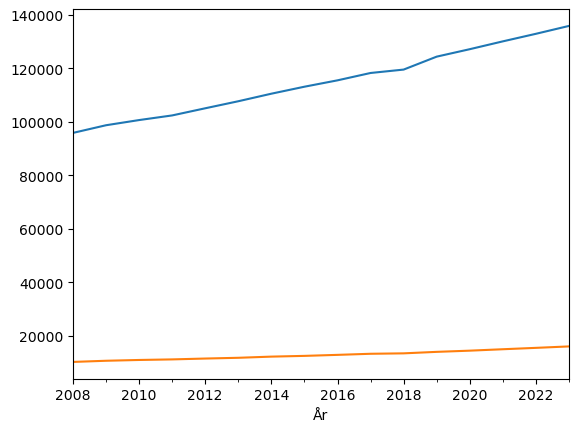

In [118]:
df = pd.read_csv("helsepersonell.csv", encoding="ISO-8859-1", sep=";", header=1)

#Smelt dataframe: Beholde alt unntatt Årene
df = df.melt(id_vars=["statistikkvariabel", "fagutdanning", "alder", "kjønn"], var_name="År", value_name="antall")

#Bytt ut .. med nan for manglende verdier
df = df.replace("..", np.nan)

#Skift datatypen til antall til int32
df = df.astype({"antall": "float64"})

#Skift datatype til "år" til pd.periods
df["År"] = pd.PeriodIndex(df["År"], freq="Y")

#Velg ut kun "sykepleiere" og kun data for antall personer og sysselsatte
df = df.query("fagutdanning == 'Sykepleier' and statistikkvariabel in ['Personer', 'Sysselsatte']")

df = df.astype({"antall": "int32"})


#Lag pivottabell -- index år/kjønn, kolonner fra "statistikkvariabel" og "alder" og verdier i tabell fra values
df = df.pivot(columns=["statistikkvariabel", "alder"], index=["År", "kjønn"], values="antall")

#lag nytt dataframe med kolonnene under Personer -> Alle aldre
df_personer = df["Personer"]
df_sysselsatte = df["Sysselsatte"]

#Hent ut kun for kvinnger og plot
df.xs("Kvinner", level="kjønn")[("Personer", "Alle aldre")].plot()
#Hent ut kun menn og plot
df.xs("Menn", level="kjønn")[("Personer", "Alle aldre")].plot()